# Урок: GAN

## Задание: 

* Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети
* Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

## Импорт библиотек

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import os
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_num = 0
batch_size = 32
indices_train = np.where(y_train == class_num)
indices_test = np.where(y_test == class_num)

all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
indices_train = np.where(y_train == class_num)
indices_test = np.where(y_test == class_num)
all_digits = all_digits[indices_train,:,:]
all_digits = np.reshape(all_digits, (-1, 32, 32, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

print('all_digits shape:', all_digits.shape)

all_digits shape: (30000, 32, 32, 1)


In [3]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

In [4]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32 * 32 * 64),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((32, 32, 64)),
        layers.Conv2DTranspose(64, (3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (32, 32), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             4259840   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       147712    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0 

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в текзор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


In [6]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=64):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


In [7]:
epochs = 25

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.SGD(),
    g_optimizer=keras.optimizers.SGD(),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/25
938/938 [==============================] - 72s 68ms/step - d_loss: 0.5912 - g_loss: 0.8171
Epoch 2/25
938/938 [==============================] - 60s 64ms/step - d_loss: 0.4121 - g_loss: 1.3878
Epoch 3/25
938/938 [==============================] - 60s 64ms/step - d_loss: 0.0282 - g_loss: 4.6655
Epoch 4/25
938/938 [==============================] - 60s 64ms/step - d_loss: -0.0190 - g_loss: 8.2458
Epoch 5/25
938/938 [==============================] - 60s 64ms/step - d_loss: -0.0738 - g_loss: 13.5393
Epoch 6/25
938/938 [==============================] - 61s 65ms/step - d_loss: -0.1775 - g_loss: 24.0063
Epoch 7/25
938/938 [==============================] - 60s 64ms/step - d_loss: -0.2620 - g_loss: 38.1753
Epoch 8/25
938/938 [==============================] - 60s 64ms/step - d_loss: 0.1760 - g_loss: 6.5088
Epoch 9/25
938/938 [==============================] - 61s 65ms/step - d_loss: 0.2888 - g_loss: 2.9156
Epoch 10/25
938/938 [==============================] - 61s 65ms/step - d_lo

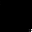

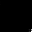

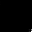

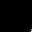

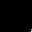

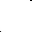

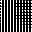

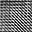

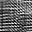

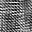

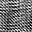

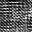

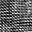

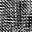

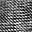

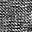

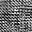

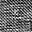

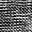

In [8]:
from IPython.display import Image, display

for i in range(1,20):
  display(Image("generated_img_0_"+str(i)+".png"))

## Анализ

* `latent_dim` установлен равным 64
* количество эпох 25
* оптимизатор `SGD`

## DenseNet

[https://arxiv.org/pdf/1608.06993.pdf](https://arxiv.org/pdf/1608.06993.pdf)

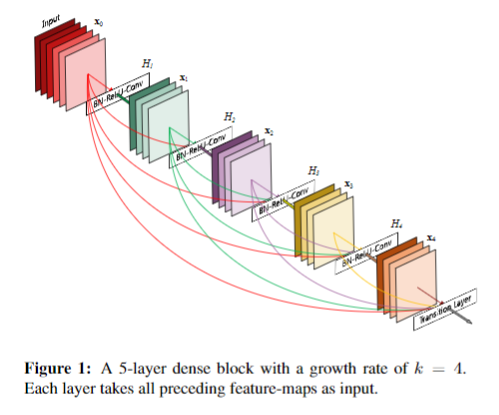

* каждый слой соединяется с каждым другим слоем прямой связью
* для каждого слоя карты всех предыдущих слоев используются в качестве входных данных, а его собственные карты используются в качестве входных данных для всех последующих слоев
* преимущества: устраняют проблему исчезающего градиента, усиливают распространение функций, существенно сокращают количество параметров